# ASSIGNMENT Using SVM

## By Naveed Jeddy

### Note: The code for Google Colab has been commented out as Markdown

DATA_FOLDER_ID = '1qctH1mWSE5yA2NPyys1LjUcTqZOr3smt'
ROOT_PATH = '~/you_path'
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_root_path = os.path.expanduser(ROOT_PATH)
try:
  os.makedirs(local_root_path)
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))

ListFolder(DATA_FOLDER_ID, local_root_path)


ls /root/you_path


In [0]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [0]:
# load the data
train = pd.read_csv("/root/you_path/train.csv")
test =  pd.read_csv("/root/you_path/test.csv")

## Data Understanding

Let's first load the data and understand the attributes meanings, shape of the dataset etc.

In [0]:
#read train data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
#read test data
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
train.shape

(42000, 785)

> Train dataset has 42000 rows and 785 Columns

In [0]:
test.shape

(28000, 784)

> Test dataset has 28000 rows and 784 Columns i.e. minus label

In [0]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [0]:
test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


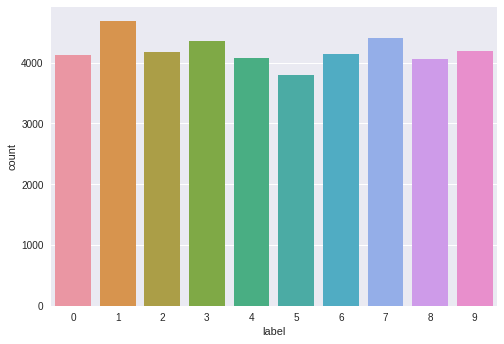

In [0]:
# Checking the distribution of label column
sns.countplot(train['label'])
plt.show()

> All digits 0-9 seems to be evenly distributed with digit 1 leading than the others

In [0]:
order = list(np.sort(train['label'].unique()))
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


> There are no duplicate digits ..just a check

In [0]:
digit_means = train.groupby('label').mean()
digit_means.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.846626,0.939105,0.397182,0.086344,0.118155,0.027267,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


## Data Preparation

Let's conduct some data preparation steps before modeling. Firstly, let's see if it is important to **rescale** the features, since they may have varying ranges. For example, here are the average values:

In [0]:
# To check Null Values in different columns
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
           ..
pixel754    0
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

> There are no Nulls

In [0]:
# average feature values
round(train.drop('label', axis=1).mean(), 2)

pixel0      0.00
pixel1      0.00
pixel2      0.00
pixel3      0.00
pixel4      0.00
pixel5      0.00
pixel6      0.00
pixel7      0.00
pixel8      0.00
pixel9      0.00
pixel10     0.00
pixel11     0.00
pixel12     0.00
pixel13     0.01
pixel14     0.01
pixel15     0.00
pixel16     0.00
pixel17     0.00
pixel18     0.00
pixel19     0.00
pixel20     0.00
pixel21     0.00
pixel22     0.00
pixel23     0.00
pixel24     0.00
pixel25     0.00
pixel26     0.00
pixel27     0.00
pixel28     0.00
pixel29     0.00
            ... 
pixel754    0.00
pixel755    0.00
pixel756    0.00
pixel757    0.00
pixel758    0.00
pixel759    0.00
pixel760    0.00
pixel761    0.01
pixel762    0.04
pixel763    0.08
pixel764    0.11
pixel765    0.18
pixel766    0.30
pixel767    0.41
pixel768    0.51
pixel769    0.56
pixel770    0.68
pixel771    0.60
pixel772    0.49
pixel773    0.34
pixel774    0.22
pixel775    0.12
pixel776    0.06
pixel777    0.02
pixel778    0.02
pixel779    0.00
pixel780    0.00
pixel781    0.

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Splitting the Original Train Dataset and picking 30% of the original data for further processing

In [0]:
digits_A, digits_B = train_test_split(train,test_size=0.3,random_state=4)

In [0]:
digits_A.shape

(29400, 785)

In [0]:
digits_B.shape

(12600, 785)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


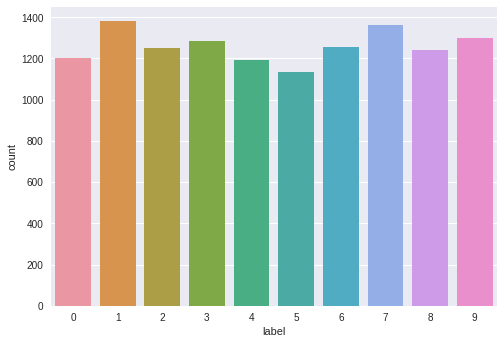

In [0]:
# Checking the distribution of label column
sns.countplot(digits_B['label'])
plt.show()

The sub-sample of Original data  also has a even spread of all digits 0-9

In [0]:
# splitting into X and y
X = digits_B.drop("label", axis = 1)
y = digits_B['label']

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
X_scaled  = scaler.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
X_scaled.shape

(12600, 784)

In [0]:
## Now splitting the sub-sample data i.e 30% of original into train and test for building the model
# train validate split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 101)

In [0]:
X_train.shape

(10080, 784)

In [0]:
y_train.shape

(10080,)

In [0]:
X_test.shape

(2520, 784)

In [0]:
y_test.shape

(2520,)

> From the Original dataset of 42000 rows, 30% of data i.e. 12600 rows were sampled
> then from the sub-set of 12600 rows, 80% were picked for training i.e. 10080 rows and 20% i.e. 2520 rows for test during training....For Evaluation of the model test.csv will be used... 

## Model Building

Let's first build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [0]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [0]:
# confusion matrix and accuracy

# accuracy
print("accuracy - Linear:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy - Linear: 0.9063492063492063 

[[214   0   1   0   0   1   0   0   0   0]
 [  0 293   3   1   0   0   0   0   3   0]
 [  4   5 235   6   4   0   4   2   6   0]
 [  2   3   9 213   2  15   0   3   5   1]
 [  1   1   0   0 225   0   1   0   0   9]
 [  2   1   5  15   4 177   4   1   1   3]
 [  1   0   0   0   2   2 243   0   2   2]
 [  1   1   5   3   1   0   0 233   1  14]
 [  2   4   8  16   2  11   1   1 199   3]
 [  1   1   0   3  11   0   0   7   2 252]]


The linear model gives approx. 91% accuracy. Let's look at  non-linear model with randomly chosen hyperparameters.

In [0]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
# confusion matrix and accuracy

# accuracy
print("accuracy - RBF:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy - RBF: 0.9115079365079365 

[[210   0   0   0   0   2   3   0   1   0]
 [  0 290   1   2   0   0   1   0   5   1]
 [  1   3 228   5   9   2   5   5   8   0]
 [  1   2   2 218   1  11   2   4   7   5]
 [  0   0   1   0 225   2   1   0   0   8]
 [  0   2   1  12   3 183   8   1   2   1]
 [  2   0   0   0   2   3 243   0   2   0]
 [  3   3   6   1   2   0   0 231   1  12]
 [  0   3   2   8   1   8   3   0 218   4]
 [  1   1   0   5   7   2   0   6   4 251]]


>> The non-linear RBF model also has given almost same 91% accuracy just littlemore than the linear model

In [0]:
# non-linear model
# using poly kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='poly')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
# confusion matrix and accuracy

# accuracy
print("accuracy - Polynomial:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy - Polynomial: 0.13373015873015873 

[[ 62   0   0   0   0   0   0 154   0   0]
 [  0   0   0   0   0   0   0 300   0   0]
 [  0   1   3   1   0   0   0 261   0   0]
 [  0   4   0   4   0   0   0 245   0   0]
 [  0   0   0   0   0   0   0 237   0   0]
 [  0   0   0   1   0   0   0 212   0   0]
 [  0   3   0   0   0   0   7 242   0   0]
 [  0   0   0   0   0   0   0 259   0   0]
 [  0   0   0   5   0   0   0 240   2   0]
 [  0   0   0   0   0   0   0 277   0   0]]


Polynomial model has given only 13% accuracy...the best accuracy was given by RBF...we will drop Polynomial model from further steps

## Grid Search: Hyperparameter Tuning _ Linear

Let's now tune the model to find the optimal values of C and gamma corresponding to an Linear kernel. We'll use 5-fold cross validation.

In [0]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5,  shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100]}]


# specify model
model = SVC(kernel="linear")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model,
                        n_jobs=-1,
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  



Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 13.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [0]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.233120,0.107718,4.857437,0.069115,1,0.01,"{'C': 1, 'gamma': 0.01}",0.910218,0.922619,0.914187,...,0.913294,0.005554,1,0.998016,0.997768,0.99752,0.99752,0.99814,0.997793,0.000253
1,11.807128,0.806997,4.887665,0.084251,1,0.001,"{'C': 1, 'gamma': 0.001}",0.910218,0.922619,0.914187,...,0.913294,0.005554,1,0.998016,0.997768,0.99752,0.99752,0.99814,0.997793,0.000253
2,11.174675,0.055482,4.817897,0.063521,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.910218,0.922619,0.914187,...,0.913294,0.005554,1,0.998016,0.997768,0.99752,0.99752,0.99814,0.997793,0.000253
3,11.350157,0.146205,4.866592,0.057423,10,0.01,"{'C': 10, 'gamma': 0.01}",0.905258,0.919147,0.909722,...,0.909921,0.006120,4,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,0.000000
4,11.199428,0.137513,4.854891,0.040720,10,0.001,"{'C': 10, 'gamma': 0.001}",0.905258,0.919147,0.909722,...,0.909921,0.006120,4,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,0.000000
5,11.104617,0.137508,4.812695,0.064852,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.905258,0.919147,0.909722,...,0.909921,0.006120,4,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,0.000000
6,11.276085,0.117221,4.871809,0.085495,100,0.01,"{'C': 100, 'gamma': 0.01}",0.905258,0.919147,0.909722,...,0.909921,0.006120,4,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,0.000000
7,11.204168,0.088571,4.813388,0.063266,100,0.001,"{'C': 100, 'gamma': 0.001}",0.905258,0.919147,0.909722,...,0.909921,0.006120,4,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,0.000000
8,11.019483,0.494804,4.776511,0.353218,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.905258,0.919147,0.909722,...,0.909921,0.006120,4,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,0.000000


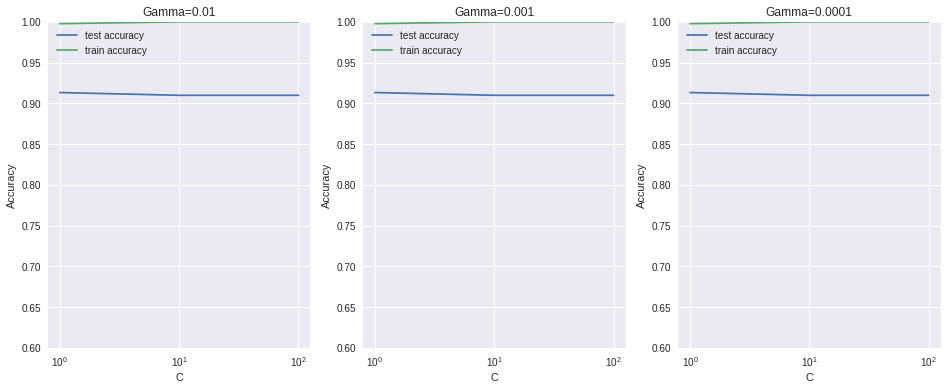

In [0]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')



In [0]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score of LINEAR MODEL is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score of LINEAR MODEL is 0.9132936507936508 corresponding to hyperparameters {'C': 1, 'gamma': 0.01}


Though the score for Linear model is 91%. The above plot doesn't seem to be right...let's choose RBF model for GridSearch CV

In [0]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)
 
# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        n_jobs = -1,
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  




Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 28.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [0]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,18.756888,0.271126,8.618830,0.068393,1,0.01,"{'C': 1, 'gamma': 0.01}",0.957837,0.958829,0.954861,...,0.955456,0.002556,3,0.978547,0.979663,0.979043,0.979415,0.980283,0.979390,0.000584
1,30.655796,0.227633,12.953971,0.148376,1,0.001,"{'C': 1, 'gamma': 0.001}",0.917163,0.917659,0.913194,...,0.911210,0.007404,7,0.917907,0.918651,0.917039,0.921875,0.917287,0.918552,0.001753
2,79.257551,0.653181,20.467588,0.145436,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.838790,0.842262,0.813988,...,0.829266,0.010336,9,0.835069,0.836930,0.831721,0.838914,0.829365,0.834400,0.003457
3,16.171746,0.466348,8.071731,0.146414,10,0.01,"{'C': 10, 'gamma': 0.01}",0.968750,0.965774,0.963790,...,0.965278,0.002033,1,0.999380,0.999504,0.999504,0.999504,0.999380,0.999454,0.000061
4,14.123536,0.130116,7.577173,0.172340,10,0.001,"{'C': 10, 'gamma': 0.001}",0.934524,0.941468,0.937004,...,0.935417,0.004167,5,0.961682,0.959449,0.959201,0.959697,0.959573,0.959921,0.000896
5,29.690202,0.240298,12.840468,0.149172,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.914683,0.913690,0.911210,...,0.908333,0.007218,8,0.914931,0.916915,0.914311,0.919023,0.914435,0.915923,0.001811
6,16.238039,0.250979,8.039046,0.442570,100,0.01,"{'C': 100, 'gamma': 0.01}",0.968254,0.963790,0.964782,...,0.965079,0.001735,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,11.903711,0.218015,6.318890,0.105449,100,0.001,"{'C': 100, 'gamma': 0.001}",0.941468,0.942460,0.939980,...,0.939980,0.002196,4,0.995412,0.994792,0.995164,0.994420,0.994544,0.994866,0.000373
8,14.096304,0.442011,7.370143,0.124983,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.927579,0.935516,0.927579,...,0.928472,0.004306,6,0.955233,0.953497,0.953745,0.952877,0.953125,0.953695,0.000825


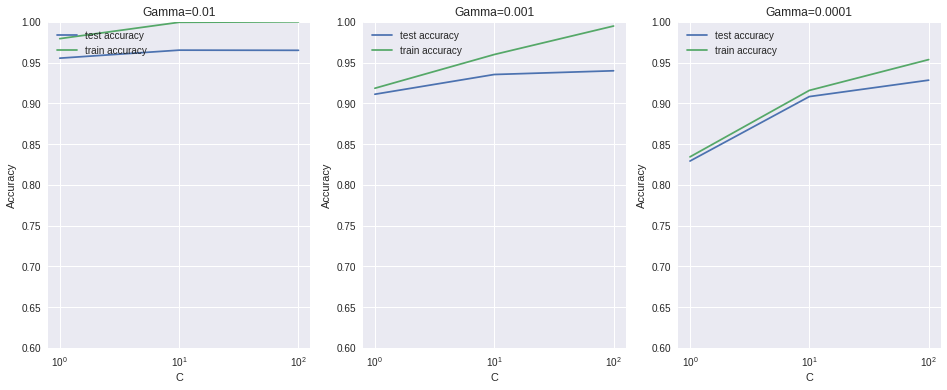

In [0]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')




In [0]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score of RBF MODEL is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score of RBF MODEL is 0.9652777777777778 corresponding to hyperparameters {'C': 10, 'gamma': 0.01}


RBF model has performed much better than the Linear model...with 97%...we will be using RBF model for evaluation of the model..

# Evaluation of the Model

In [0]:
test.shape

(28000, 784)

In [0]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.01, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
print(metrics.confusion_matrix(y_test, y_pred), "\n")

accuracy 0.9718253968253968 

[[216   0   0   0   0   0   0   0   0   0]
 [  0 295   2   1   0   0   1   0   1   0]
 [  3   2 253   2   2   1   1   0   2   0]
 [  1   0   3 241   0   4   0   2   0   2]
 [  0   1   0   0 233   0   1   0   0   2]
 [  1   0   2   5   0 203   1   0   0   1]
 [  1   0   0   0   2   1 246   0   2   0]
 [  1   1   1   0   0   0   0 255   1   0]
 [  0   1   1   7   0   0   0   0 238   0]
 [  0   0   0   1   3   1   0   1   2 269]] 



In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix
model_acc = model.score(X_test, y_test)
test_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test,y_pred)

In [62]:
print('\nSVM Trained Classifier Accuracy: ', model_acc)
print('\nPredicted Values: ',y_pred)
print('\nAccuracy of Classifier on Validation Images: ',test_acc)
print('\nConfusion Matrix: \n',conf_mat)


SVM Trained Classifier Accuracy:  0.9718253968253968

Predicted Values:  [3 2 1 ... 6 4 3]

Accuracy of Classifier on Validation Images:  0.9718253968253968

Confusion Matrix: 
 [[216   0   0   0   0   0   0   0   0   0]
 [  0 295   2   1   0   0   1   0   1   0]
 [  3   2 253   2   2   1   1   0   2   0]
 [  1   0   3 241   0   4   0   2   0   2]
 [  0   1   0   0 233   0   1   0   0   2]
 [  1   0   2   5   0 203   1   0   0   1]
 [  1   0   0   0   2   1 246   0   2   0]
 [  1   1   1   0   0   0   0 255   1   0]
 [  0   1   1   7   0   0   0   0 238   0]
 [  0   0   0   1   3   1   0   1   2 269]]


Got a Accuracy of 97% accuracy

Using test dataset for prediction of results and using the same for Kaggle submission

In [0]:
sc_test = scaler.transform(test)

In [0]:
result = model.predict(sc_test)

In [0]:
submission = pd.Series(result,name="Label")

In [0]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),submission],axis = 1)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [0]:
submission.to_csv("/root/you_path/submission.csv")

In [0]:
from google.colab import files

files.download("/root/you_path/submission.csv")

The file was submiited in Kaggle and for a score of 0.96357 and ranked at ##2248